# Bias Removal Demonstration using VIBE
*Note: The following code, used to evaluate the advantages of the VIBE framework, was generated using GitHub Copilot (a language model). **However, the core VIBE framework itself was implemented by the author, Keshav Gupta**.*

- This notebook demonstrates the use of VIBE (Variational Information Bottleneck for Embedding) for removing bias from text embeddings. We'll use the IMDb Movie Reviews dataset to show how we can remove genre-based bias from sentiment analysis predictions.

- The goal is to ensure that our sentiment predictions are not unfairly influenced by movie genres (e.g., preventing the model from automatically rating dramas more positively than other genres).

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load IMDb Dataset
from datasets import load_dataset
import re

# Load the IMDb dataset
dataset = load_dataset("imdb", split="train")
df = pd.DataFrame(dataset)

# Function to determine if a review is about an action movie or drama
def classify_genre(text):
    text_lower = text.lower()
    
    # Keywords that strongly indicate action movies
    action_keywords = ['action', 'explosion', 'fight', 'chase', 'thriller', 
                      'action-packed', 'stunts', 'superhero', 'battle']
    
    # Keywords that strongly indicate drama
    drama_keywords = ['drama', 'emotional', 'dramatic', 'relationship', 
                     'character study', 'touching', 'powerful story']
    
    action_count = sum(1 for word in action_keywords if word in text_lower)
    drama_count = sum(1 for word in drama_keywords if word in text_lower)
    
    # Only classify if we can make a clear distinction
    if action_count > drama_count:
        return 1  # Action
    elif drama_count > action_count:
        return 0  # Drama
    else:
        return None  # Unclear, will be filtered out

# Create binary labels
df['is_action'] = df['text'].apply(classify_genre)

# Remove unclear cases and create balanced dataset
df_clear = df.dropna(subset=['is_action'])
action_samples = df_clear[df_clear['is_action'] == 1].sample(2000, random_state=42)
drama_samples = df_clear[df_clear['is_action'] == 0].sample(2000, random_state=42)
df_balanced = pd.concat([action_samples, drama_samples])

# Prepare final labels
df_balanced['is_positive'] = df_balanced['label'].astype(int)  # Sentiment (main task)
df_balanced['is_action'] = df_balanced['is_action'].astype(int)  # Genre (protected attribute)

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Dataset shape:", df_balanced.shape)
print("\nSentiment distribution:")
print(df_balanced['is_positive'].value_counts(normalize=True))
print("\nGenre distribution:")
print(df_balanced['is_action'].value_counts(normalize=True))

# Show genre bias in sentiment
sentiment_by_genre = df_balanced.groupby('is_action')['is_positive'].mean()
print("\nAverage sentiment score by genre:")
print("Drama (0):", sentiment_by_genre[0])
print("Action (1):", sentiment_by_genre[1])

# Display example reviews
print("\nExample reviews:")
print(df_balanced[['text', 'is_positive', 'is_action']].head(2))
df_balanced.to_csv('balanced_imdb_reviews.csv', index=False)

Dataset shape: (4000, 4)

Sentiment distribution:
is_positive
1    0.5635
0    0.4365
Name: proportion, dtype: float64

Genre distribution:
is_action
1    0.5
0    0.5
Name: proportion, dtype: float64

Average sentiment score by genre:
Drama (0): 0.64
Action (1): 0.487

Example reviews:
                                                text  is_positive  is_action
0  I have seen many good Korean Movies including ...            0          1
1  Alan Johnson (Don Cheadle) is a successful den...            1          0


In [6]:
from Encoder import Encoder
encoder = Encoder('balanced_imdb_reviews.csv')
input_data, output_data = encoder.encode(input_column='text', output_column='is_action')

**** Generating the Embeddings of the input data ****
**** Embeddings generation completed ****
**** Embeddings generation completed ****


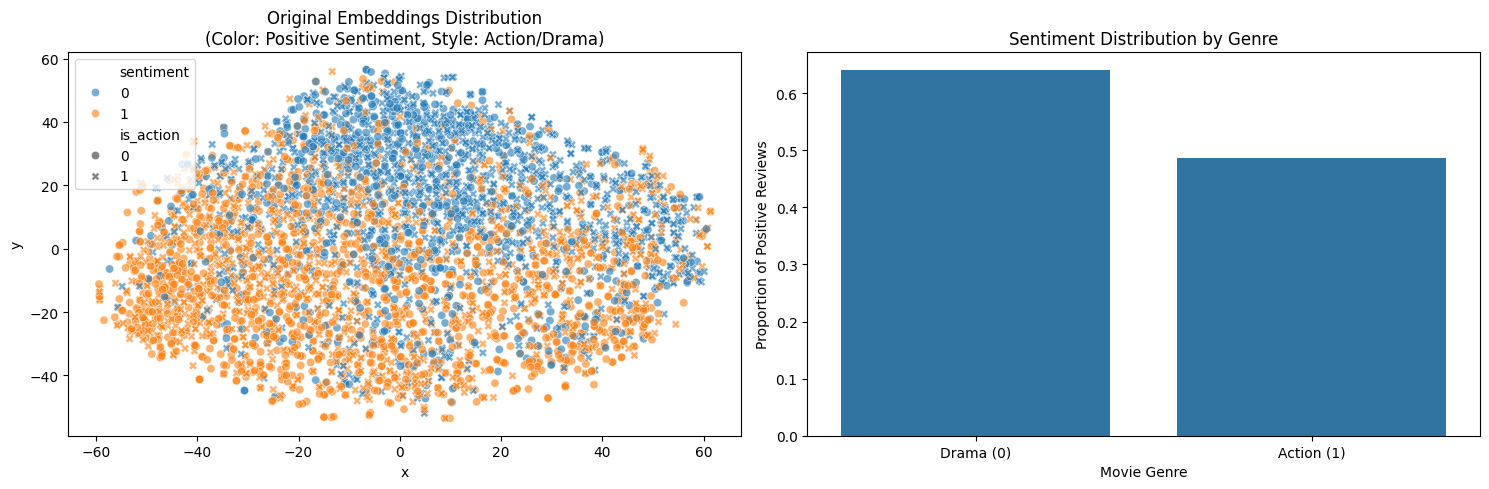

Sentiment Distribution Analysis:
Drama: 64.00% positive reviews
Action: 48.70% positive reviews


In [9]:
import seaborn as sns
# Reduce dimensionality for visualization
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(input_data)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_pca)

# Create visualization DataFrame
viz_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'sentiment': df_balanced['is_positive'],
    'is_action': df_balanced['is_action']
})

# Plot original embeddings distribution
plt.figure(figsize=(15, 5))

# Plot by sentiment
plt.subplot(121)
sns.scatterplot(data=viz_df, x='x', y='y', hue='sentiment', style='is_action', alpha=0.6)
plt.title('Original Embeddings Distribution\n(Color: Positive Sentiment, Style: Action/Drama)')

# Plot sentiment distribution by genre
plt.subplot(122)
sentiment_by_genre = df_balanced.groupby('is_action')['is_positive'].mean()
sns.barplot(x=['Drama (0)', 'Action (1)'], y=sentiment_by_genre.values)
plt.xlabel('Movie Genre')
plt.ylabel('Proportion of Positive Reviews')
plt.title('Sentiment Distribution by Genre')

plt.tight_layout()
plt.show()

# Print statistical analysis
print("Sentiment Distribution Analysis:")
for genre, genre_name in [(0, 'Drama'), (1, 'Action')]:
    genre_data = df_balanced[df_balanced['is_action'] == genre]
    pos_rate = (genre_data['is_positive'] == 1).mean()
    print(f"{genre_name}: {pos_rate:.2%} positive reviews")

In [1]:
from vibe import VIBE
sentiment_model_orchestrator = VIBE('text', 'is_action', 'balanced_imdb_reviews.csv', hidden_layer_sizes=[256, 512, 256], enable_debiasing=True, epochs=500, learning_rate=0.001)
sentiment_model_orchestrator.run()
debiased_input = sentiment_model_orchestrator.fetch_debiased_embeddings()

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


==== Started the execution ==== 
**** Generating the Embeddings of the input data ****


/opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


**** Embeddings generation completed ****
 ==> Epoch: 0 Training Loss: tensor(0.7315, grad_fn=<BinaryCrossEntropyBackward0>)
 ==> Epoch: 1 Training Loss: tensor(0.7259, grad_fn=<BinaryCrossEntropyBackward0>)
 ==> Epoch: 2 Training Loss: tensor(0.7311, grad_fn=<BinaryCrossEntropyBackward0>)
 ==> Epoch: 3 Training Loss: tensor(0.7268, grad_fn=<BinaryCrossEntropyBackward0>)
 ==> Epoch: 4 Training Loss: tensor(0.7336, grad_fn=<BinaryCrossEntropyBackward0>)
 ==> Epoch: 5 Training Loss: tensor(0.7185, grad_fn=<BinaryCrossEntropyBackward0>)
 ==> Epoch: 6 Training Loss: tensor(0.7210, grad_fn=<BinaryCrossEntropyBackward0>)
 ==> Epoch: 7 Training Loss: tensor(0.7186, grad_fn=<BinaryCrossEntropyBackward0>)
 ==> Epoch: 1 Training Loss: tensor(0.7259, grad_fn=<BinaryCrossEntropyBackward0>)
 ==> Epoch: 2 Training Loss: tensor(0.7311, grad_fn=<BinaryCrossEntropyBackward0>)
 ==> Epoch: 3 Training Loss: tensor(0.7268, grad_fn=<BinaryCrossEntropyBackward0>)
 ==> Epoch: 4 Training Loss: tensor(0.7336, g

In [15]:
# Implement code to predict the sentiment of the debiased embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
# Split the debiased embeddings into training and test sets
X_train, X_test, y_train, y_test = train_test_split(debiased_input.detach().numpy(), df_balanced['is_positive'], test_size=0.2, random_state=42)
# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
# Predict sentiment on the test set
y_pred = model.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Debiased Model Accuracy: {accuracy:.4f}")
debiased_preds = model.predict(debiased_input.detach().numpy())

Debiased Model Accuracy: 0.7212


Text(0.5, 1.0, 'Debiased Embeddings')

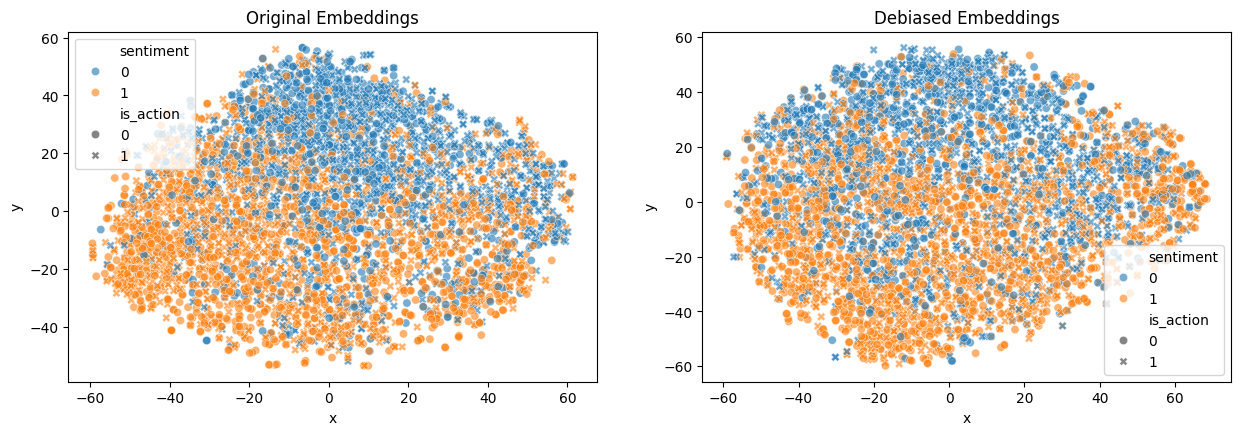

In [ ]:
import seaborn as sns
# Get debiased embeddings
debiased_embeddings = sentiment_model_orchestrator.fetch_debiased_embeddings().detach().numpy()

# Reduce dimensionality for visualization
debiased_pca = PCA(n_components=50)
debiased_embeddings_pca = debiased_pca.fit_transform(debiased_embeddings)

debiased_tsne = TSNE(n_components=2, random_state=42)
debiased_embeddings_2d = debiased_tsne.fit_transform(debiased_embeddings_pca)

# Create visualization DataFrame for debiased embeddings
debiased_viz_df = pd.DataFrame({
    'x': debiased_embeddings_2d[:, 0],
    'y': debiased_embeddings_2d[:, 1],
    'sentiment': df_balanced['is_positive'],
    'is_action': df_balanced['is_action']
})

# Plot comparison
plt.figure(figsize=(15, 10))

# Original embeddings
plt.subplot(221)
sns.scatterplot(data=viz_df, x='x', y='y', hue='sentiment', style='is_action', alpha=0.6)
plt.title('Original Embeddings')

# Debiased embeddings
plt.subplot(222)
sns.scatterplot(data=debiased_viz_df, x='x', y='y', hue='sentiment', style='is_action', alpha=0.6)
plt.title('Debiased Embeddings')




Bias Metrics Comparison:
Original Embeddings:
- Mean correlation with action genre: 0.00000000
- Max correlation with action genre: 0.00000000
- Prediction disparity between genres: 0.15300000
- Valid correlations: 0/768

Debiased Embeddings:
- Mean correlation with action genre: 0.04704591
- Max correlation with action genre: 0.21402387
- Prediction disparity between genres: 0.13400000
- Valid correlations: 767/768

Reduction in correlation: -inf%
Reduction in prediction disparity: 12.42%


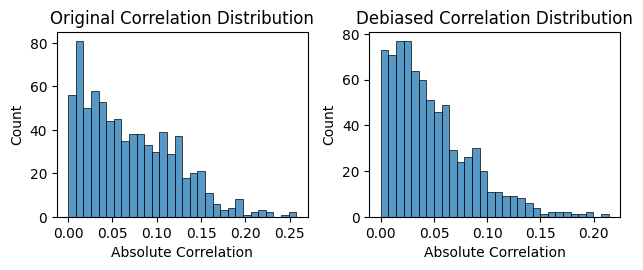

In [23]:
def calculate_bias_metrics(embeddings, protected_attribute, labels):
    """
    Calculate bias metrics with proper handling of edge cases and numerical stability.
    
    Args:
        embeddings: numpy array of embeddings
        protected_attribute: binary protected attribute values
        labels: prediction labels
    """
    # Normalize embeddings for numerical stability
    embeddings = (embeddings - embeddings.mean(axis=0)) / (embeddings.std(axis=0) + 1e-8)
    
    # Calculate correlations safely
    correlations = []
    for i in range(embeddings.shape[1]):
        try:
            # Skip if there's no variation in the embedding dimension
            if np.std(embeddings[:, i]) < 1e-8:
                continue
                
            corr = np.corrcoef(embeddings[:, i], protected_attribute)[0, 1]
            # Only include if correlation is valid
            if not np.isnan(corr):
                correlations.append(abs(corr))
        except:
            continue
    
    # Convert to numpy array for calculations
    correlations = np.array(correlations)
    
    # Calculate prediction rates for each group
    group_0_pred = labels[protected_attribute == 0].mean()
    group_1_pred = labels[protected_attribute == 1].mean()
    
    return {
        'mean_correlation': correlations.mean() if len(correlations) > 0 else 0.0,
        'max_correlation': correlations.max() if len(correlations) > 0 else 0.0,
        'prediction_disparity': abs(group_1_pred - group_0_pred),
        'num_valid_correlations': len(correlations),
        'total_dimensions': embeddings.shape[1]
    }

# Calculate metrics for original embeddings
original_metrics = calculate_bias_metrics(
    input_data, 
    df_balanced['is_action'].values,
    df_balanced['is_positive'].values
)

# Calculate metrics for debiased embeddings
debiased_metrics = calculate_bias_metrics(
    debiased_embeddings,
    df_balanced['is_action'].values,
    debiased_preds
)

# Print detailed metrics
print("\nBias Metrics Comparison:")
print("Original Embeddings:")
print(f"- Mean correlation with action genre: {original_metrics['mean_correlation']:.8f}")
print(f"- Max correlation with action genre: {original_metrics['max_correlation']:.8f}")
print(f"- Prediction disparity between genres: {original_metrics['prediction_disparity']:.8f}")
print(f"- Valid correlations: {original_metrics['num_valid_correlations']}/{original_metrics['total_dimensions']}")

print("\nDebiased Embeddings:")
print(f"- Mean correlation with action genre: {debiased_metrics['mean_correlation']:.8f}")
print(f"- Max correlation with action genre: {debiased_metrics['max_correlation']:.8f}")
print(f"- Prediction disparity between genres: {debiased_metrics['prediction_disparity']:.8f}")
print(f"- Valid correlations: {debiased_metrics['num_valid_correlations']}/{debiased_metrics['total_dimensions']}")

print(f"\nReduction in correlation: {((original_metrics['mean_correlation'] - debiased_metrics['mean_correlation'])/original_metrics['mean_correlation']*100):.2f}%")
print(f"Reduction in prediction disparity: {((original_metrics['prediction_disparity'] - debiased_metrics['prediction_disparity'])/original_metrics['prediction_disparity']*100):.2f}%")

# Plot correlation distributions
plt.subplot(223)
original_correlations = np.array([abs(np.corrcoef(input_data[:, i], df_balanced['is_action'].values)[0, 1]) 
                                for i in range(input_data.shape[1])])
original_correlations = original_correlations[~np.isnan(original_correlations)]
sns.histplot(original_correlations, bins=30)
plt.title('Original Correlation Distribution')
plt.xlabel('Absolute Correlation')

plt.subplot(224)
debiased_correlations = np.array([abs(np.corrcoef(debiased_embeddings[:, i], df_balanced['is_action'].values)[0, 1]) 
                                 for i in range(debiased_embeddings.shape[1])])
debiased_correlations = debiased_correlations[~np.isnan(debiased_correlations)]
sns.histplot(debiased_correlations, bins=30)
plt.title('Debiased Correlation Distribution')
plt.xlabel('Absolute Correlation')

plt.tight_layout()
plt.show()